## Job Category Classification Using NLP

In [23]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#NLP imports
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import re

#Classification imports
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier,LogisticRegression

## Load Dataset


In [24]:
#loading data into a dataframe.
dataframe = pd.read_csv("fake_job.csv", encoding="ISO-8859-1")
dataframe.head()

,Search,Category
0,freelance web developer,Web Mobile & Software Development
1,video editing job,Video & Animation
2,legal advisor,Legal
3,software engineer,Web Mobile & Software Development
4,graphic designer freelance,Design & Creative


## Understanding the Data

In [25]:
#Each job title has an industry type. 
#The industry type is the classes and the job titles are our instances.
dataframe.info()
print("\nThere are only ",len(dataframe['Search'].unique()),"unique entries in Job Search.")
print("\nThere are only ",len(dataframe['Category'].unique()),"unique categories in Job Search.")
classes = np.array(dataframe['Search'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Search    137 non-null    object
 1   Category  137 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB

There are only  131 unique entries in Job Search.

There are only  24 unique categories in Job Search.


## Visualizing the Distribution of The Category

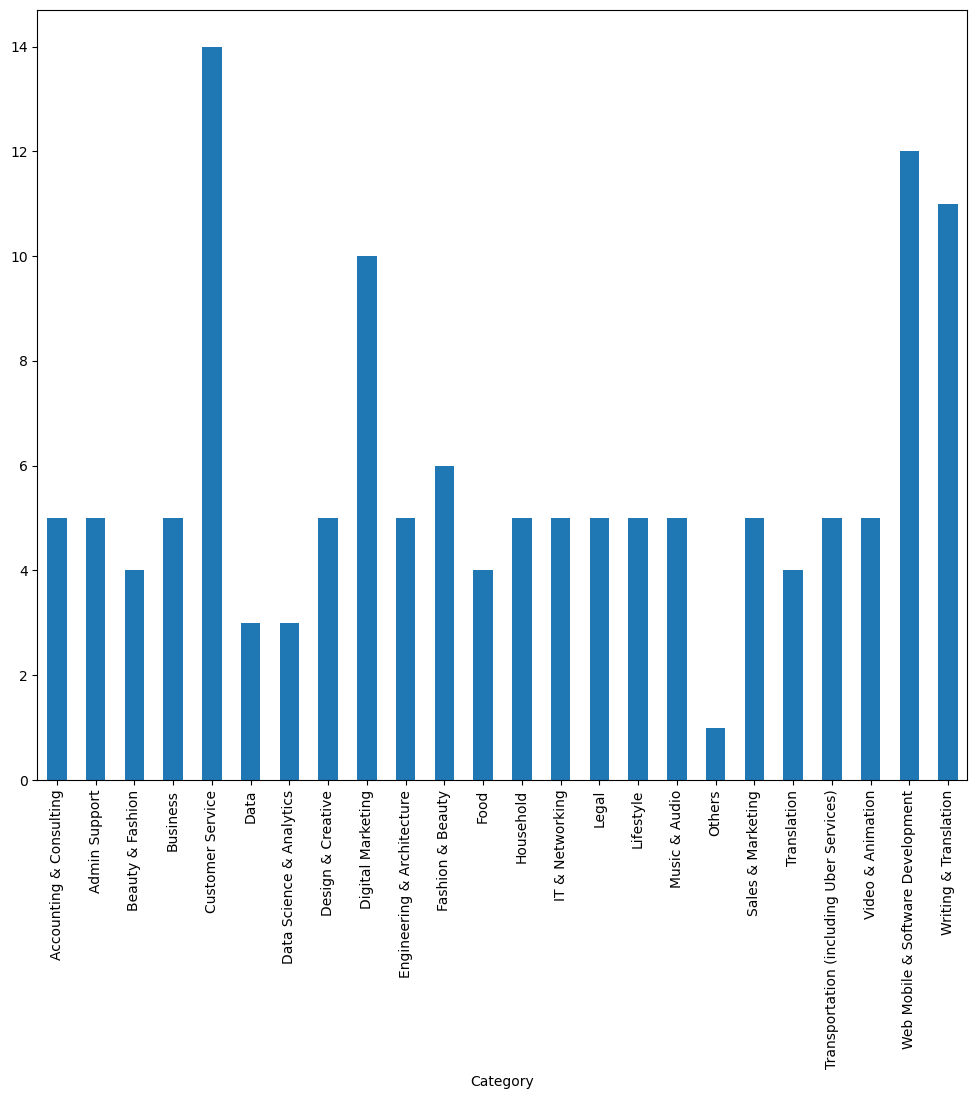

In [26]:
plt.figure(figsize=(12,10));
dataframe.groupby('Category')['Search'].count().plot.bar(ylim=0);
plt.show()

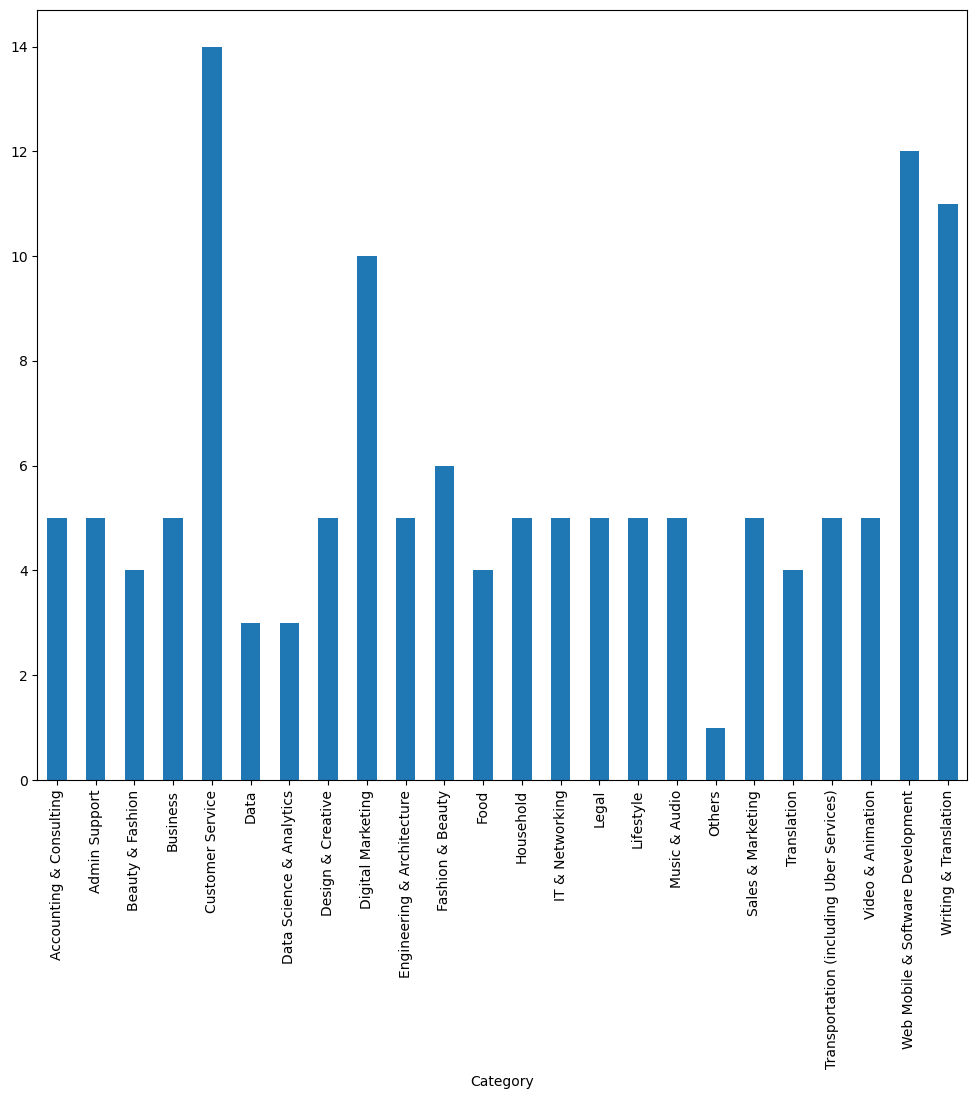

In [27]:
plt.figure(figsize=(12,10));
dataframe.groupby('Category')['Search'].count().plot.bar(ylim=0);
plt.show()

## Cleaning the data: Removing duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 134
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Search    131 non-null    object
 1   Category  131 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


<Figure size 1000x600 with 0 Axes>

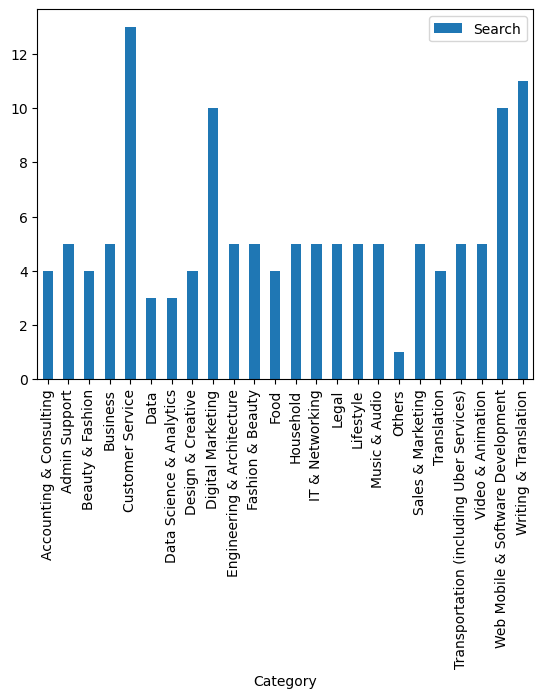

In [28]:
cleanframe = dataframe.drop_duplicates(subset="Search")
cleanframe.info()
#show the new classes distribution after removing duplicates.
plt.figure(figsize=(10,6));
cleanframe.groupby('Category').count().plot.bar(ylim=0);
plt.show();

## Cleaning the data: Text Pre-processing

In [29]:
def clean_text(text):
    """
        text: a string 
        return: modified clean string
    """
    result = ""
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) >= 2:
            token = token.lower() # lowercase text
            result+=token+" "     # append to result
    return result

cleanframe['Search'] = cleanframe['Search'].map(clean_text)
cleanframe.head()

/var/folders/8s/8kr9355d57gbx1dg94k8jmh00000gn/T/ipykernel_90429/1297990498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanframe['Search'] = cleanframe['Search'].map(clean_text)


,Search,Category
0,freelance web developer,Web Mobile & Software Development
1,video editing job,Video & Animation
2,legal advisor,Legal
3,software engineer,Web Mobile & Software Development
4,graphic designer freelance,Design & Creative


## Splitting data into test and train datasets + Dealing with class imbalance

In [30]:
X = cleanframe['Search']
y = cleanframe['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
weights = compute_sample_weight("balanced",y_train)

## The Model
### Approach 1: Naive Bayes classifier for multinomial models

In [31]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])

nb.fit(X_train, y_train, **{'clf__sample_weight': weights})

y_pred = nb.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.7575757575757576


### Approach 2: Linear SVM

In [32]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),])

sgd.fit(X_train, y_train, **{'clf__sample_weight': weights})

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.7575757575757576


## Approach 3: Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train, **{'clf__sample_weight': weights})

y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.7878787878787878


## Showing the Heat Map pf predicted classes

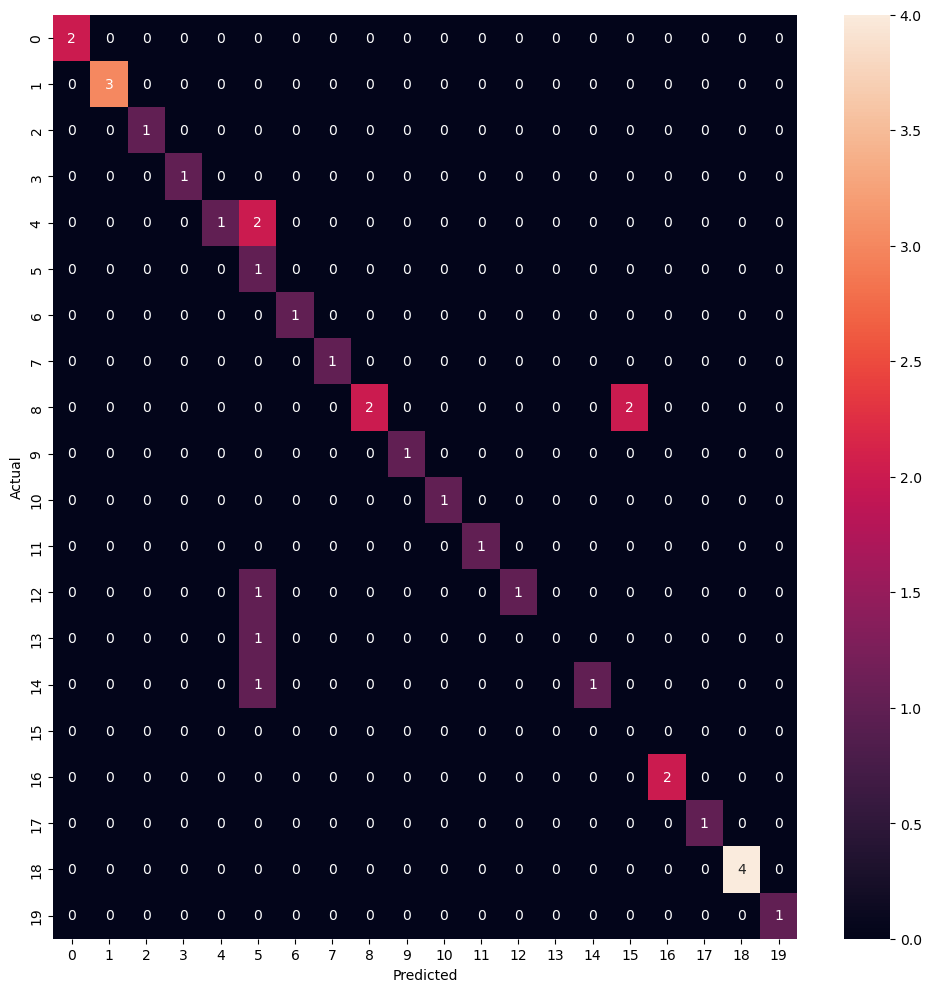

In [34]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Evaluating using F1-score for classes

In [35]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

                                          precision    recall  f1-score   support

                 Accounting & Consulting       1.00      1.00      1.00         2
                        Customer Service       1.00      1.00      1.00         3
                                    Data       1.00      1.00      1.00         1
                Data Science & Analytics       1.00      1.00      1.00         1
                       Design & Creative       1.00      0.33      0.50         3
                       Digital Marketing       0.17      1.00      0.29         1
                        Fashion & Beauty       1.00      1.00      1.00         1
                                    Food       1.00      1.00      1.00         1
                               Household       1.00      0.50      0.67         4
                         IT & Networking       1.00      1.00      1.00         1
                                   Legal       1.00      1.00      1.00         1
               

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbook/opt/an

### Save the final selected Model to a file to use directly in the RESTfull API script.

In [36]:
## save the model
from pathlib import Path
from joblib import dump, load

MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model.joblib"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
dump(logreg, MODEL_SAVE_PATH)

Saving model to: model/model.joblib


['model/model.joblib']